##### Load modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import lightgbm as lgb
from sklearn.model_selection import KFold

##### Load data

In [3]:
df = pd.read_pickle('train.pickle')
X = df.drop(columns='meter_reading')
y = df.meter_reading

##### Train models with K-Fold cross validation

In [4]:
batches = [None, None, None]

for _, df_group in df.groupby(['building_id', 'meter']):
    
    indices = df_group.index
    indices = np.array_split(indices, 3)
    
    for idx, (batch, index) in enumerate(zip(batches, indices)):
        if batch is None:
            batches[idx] = index
        else:
            batches[idx] = batch.append(index)

In [5]:
scores = {'estimator': [], 'train_score': [], 'test_score': []}
params = {
    'objective': 'regression',
    'metric': {'rmse'},
}

for _ in range(3):  
    train = batches[0].append(batches[1])
    valid = batches[-1]
    
    train = lgb.Dataset(X.loc[train], y.loc[train], categorical_feature = ['building_id', 'meter', 'site_id', 'primary_use', 'hour', 'weekday'])
    valid = lgb.Dataset(X.loc[valid], y.loc[valid], categorical_feature = ['building_id', 'meter', 'site_id', 'primary_use', 'hour', 'weekday'])
    
    estimator = lgb.train(
        params=params,
        train_set=train,
        valid_sets=(train, valid),
        num_boost_round=2000,
        early_stopping_rounds=50,
        verbose_eval=100
    )
    
    scores['estimator'].append(estimator)
    scores['train_score'].append(estimator.best_score['training']['rmse'])
    scores['test_score'].append(estimator.best_score['valid_1']['rmse'])
    
    print()
    
    batches = np.roll(batches, 1)
    gc.collect()

C:\Users\Aiden\Miniconda3\envs\ML\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\Aiden\Miniconda3\envs\ML\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.807431	valid_1's rmse: 0.974447
[200]	training's rmse: 0.752425	valid_1's rmse: 0.965919
Early stopping, best iteration is:
[158]	training's rmse: 0.766266	valid_1's rmse: 0.964129

Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 0.82509	valid_1's rmse: 0.920889
[200]	training's rmse: 0.774896	valid_1's rmse: 0.882842
[300]	training's rmse: 0.750885	valid_1's rmse: 0.868078
[400]	training's rmse: 0.732029	valid_1's rmse: 0.863439
[500]	training's rmse: 0.7181	valid_1's rmse: 0.860784
[600]	training's rmse: 0.703027	valid_1's rmse: 0.856683
[700]	training's rmse: 0.691474	valid_1's rmse: 0.854089
[800]	training's rmse: 0.681323	valid_1's rmse: 0.851986
[900]	training's rmse: 0.673802	valid_1's rmse: 0.850589
[1000]	training's rmse: 0.666915	valid_1's rmse: 0.847857
[1100]	training's rmse: 0.661549	valid_1's rmse: 0.846577
[1200]	training's rmse: 0.655369	valid_1's 

train_score    0.683735
test_score     0.913397
dtype: float64


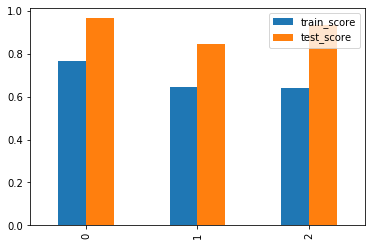

In [6]:
cols = ['train_score', 'test_score']
scores = pd.DataFrame(scores)
scores[cols] = scores[cols]
scores[cols].plot(kind='bar')
print(scores[cols].mean())

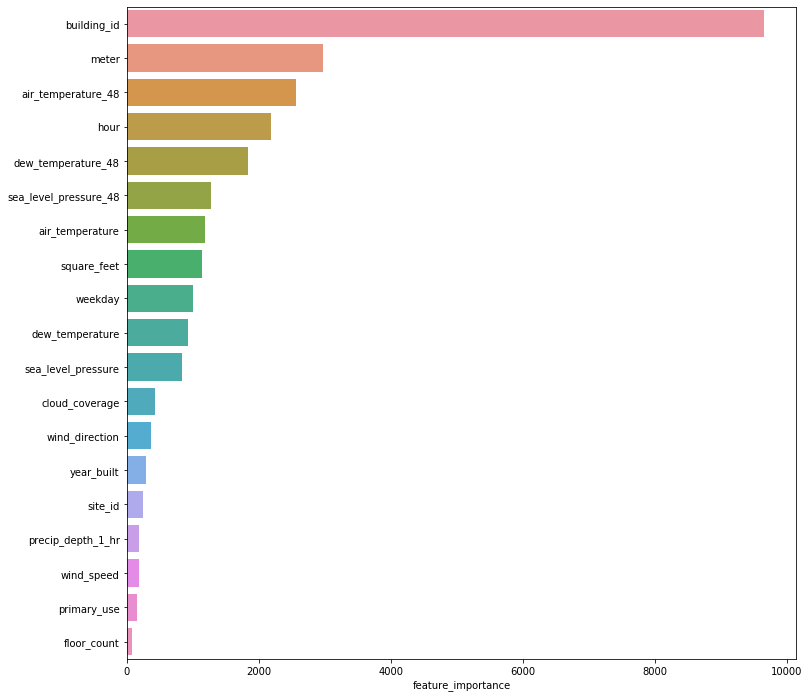

In [7]:
feature_importances = [model.feature_importance() for model in scores['estimator']]
feature_importances = np.mean(feature_importances, axis=0)
feature_importances = pd.DataFrame(data=feature_importances, index=X.columns, columns=['feature_importance'])
feature_importances.sort_values('feature_importance', ascending=False, inplace=True)

plt.figure(figsize=[12, 12])
sns.barplot(x=feature_importances.feature_importance, y=feature_importances.index, orient='h')
plt.show()

In [8]:
for idx, model in enumerate(scores['estimator']):
    model.save_model('{}.model'.format(idx))